In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as ia
import cv2 as cv
import pandas as pd
import ntpath
import random

In [2]:
columns = ["centre" , "left", "right", "steering", "throttle", "reverse", "speed"]
df = pd.read_csv('/content/drive/MyDrive/Behavioral cloning - Self Driving Car - Xcelerate/driving_log.csv', names = columns)
pd.set_option('display.max_colwidth', None)
df.head()

centre  ...     speed
0  H:\viraj\jee\VJTI\project X\behavioral cloning\term1-simulator-windows-64\DataSet\Track1\IMG\center_2024_09_27_01_28_35_951.jpg  ...  0.000079
1  H:\viraj\jee\VJTI\project X\behavioral cloning\term1-simulator-windows-64\DataSet\Track1\IMG\center_2024_09_27_01_28_36_052.jpg  ...  0.000078
2  H:\viraj\jee\VJTI\project X\behavioral cloning\term1-simulator-windows-64\DataSet\Track1\IMG\center_2024_09_27_01_28_36_154.jpg  ...  0.000078
3  H:\viraj\jee\VJTI\project X\behavioral cloning\term1-simulator-windows-64\DataSet\Track1\IMG\center_2024_09_27_01_28_36_257.jpg  ...  0.000078
4  H:\viraj\jee\VJTI\project X\behavioral cloning\term1-simulator-windows-64\DataSet\Track1\IMG\center_2024_09_27_01_28_36_358.jpg  ...  0.000080

[5 rows x 7 columns]

In [3]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

df['centre'] = df['centre'].apply(path_leaf)
df['left'] = df['left'].apply(path_leaf)
df['right'] = df['right'].apply(path_leaf)

df.head()

centre                              left  ... reverse     speed
0  center_2024_09_27_01_28_35_951.jpg  left_2024_09_27_01_28_35_951.jpg  ...     0.0  0.000079
1  center_2024_09_27_01_28_36_052.jpg  left_2024_09_27_01_28_36_052.jpg  ...     0.0  0.000078
2  center_2024_09_27_01_28_36_154.jpg  left_2024_09_27_01_28_36_154.jpg  ...     0.0  0.000078
3  center_2024_09_27_01_28_36_257.jpg  left_2024_09_27_01_28_36_257.jpg  ...     0.0  0.000078
4  center_2024_09_27_01_28_36_358.jpg  left_2024_09_27_01_28_36_358.jpg  ...     0.0  0.000080

[5 rows x 7 columns]

<BarContainer object of 25 artists>

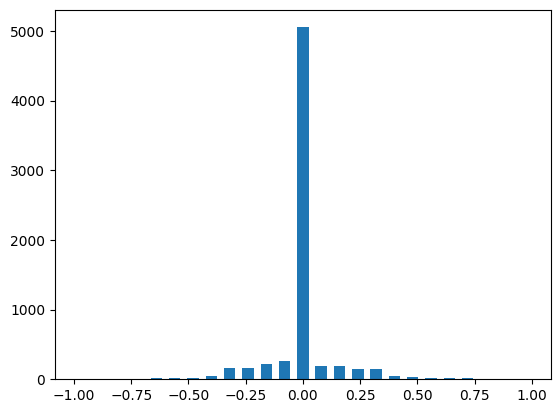

In [4]:
num_bins = 25
hist,bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width = 0.05)

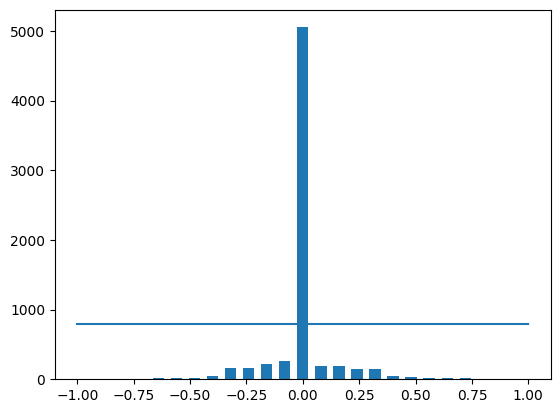

In [5]:
samples_per_bin = 800
plt.bar(center,hist,width = 0.05)
plt.plot((np.min(df['steering']),np.max(df['steering'])),(samples_per_bin,samples_per_bin))

In [6]:
df.shape

(6798, 7)

In [7]:
remove_list = []
for j in range(num_bins):
  l = []
  for i in range(len(df['steering'])):
    if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
      l.append(i)
  l = shuffle(l)
  l = l[samples_per_bin:]
  remove_list.extend(l)

print('removed : ', len(remove_list))
df.drop(df.index[remove_list], inplace = True)
print('remaining : ', len(df))

removed :  4251
remaining :  2547


<BarContainer object of 25 artists>

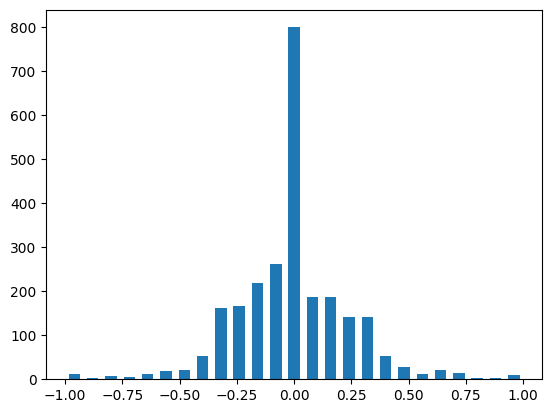

In [8]:
hist,bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width = 0.05)

In [9]:
def load_img_steering(datadir,df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    centre, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir,centre.strip()))
    steering.append(indexed_data[3])
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(indexed_data[3]+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(indexed_data[3]-0.15)
  image_path = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_path, steerings

In [10]:
img_paths, steerings = load_img_steering('/content/drive/MyDrive/Behavioral cloning - Self Driving Car - Xcelerate/IMG', df)

<ipython-input-9-5722ecd69131>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  centre, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-9-5722ecd69131>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(indexed_data[3])
<ipython-input-9-5722ecd69131>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(indexed_data[3]+0.15)
<ipython-input-9-5722ecd69131>:12: FutureWarning: Se

In [11]:
img_paths

array(['/content/drive/MyDrive/Behavioral cloning - Self Driving Car - Xcelerate/IMG/center_2024_09_27_01_28_36_154.jpg',
       '/content/drive/MyDrive/Behavioral cloning - Self Driving Car - Xcelerate/IMG/left_2024_09_27_01_28_36_154.jpg',
       '/content/drive/MyDrive/Behavioral cloning - Self Driving Car - Xcelerate/IMG/right_2024_09_27_01_28_36_154.jpg',
       ...,
       '/content/drive/MyDrive/Behavioral cloning - Self Driving Car - Xcelerate/IMG/center_2024_09_27_01_55_36_837.jpg',
       '/content/drive/MyDrive/Behavioral cloning - Self Driving Car - Xcelerate/IMG/left_2024_09_27_01_55_36_837.jpg',
       '/content/drive/MyDrive/Behavioral cloning - Self Driving Car - Xcelerate/IMG/right_2024_09_27_01_55_36_837.jpg'],
      dtype='<U111')

In [12]:
steerings

array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15])

In [13]:
len(img_paths)

7641

In [14]:
len(steerings)

7641

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(img_paths,steerings,test_size=0.25,random_state=42)
print("Training Samples : ", len(xtrain))
print("Testing Samples : ", len(xtest))

Training Samples :  5730
Testing Samples :  1911


Text(0.5, 1.0, 'Testing Set')

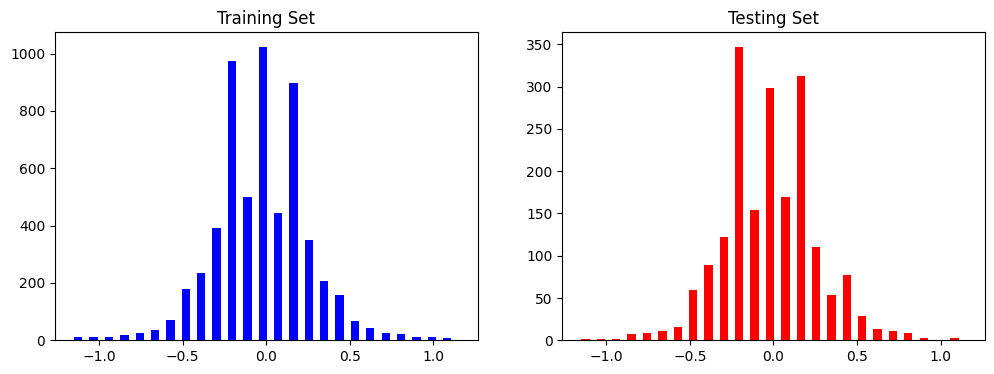

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(ytrain, bins = num_bins, width = 0.05,color='blue')
axes[0].set_title('Training Set')
axes[1].hist(ytest, bins = num_bins, width = 0.05, color = 'red')
axes[1].set_title('Testing Set')

Text(0.5, 1.0, 'Zoomed image')

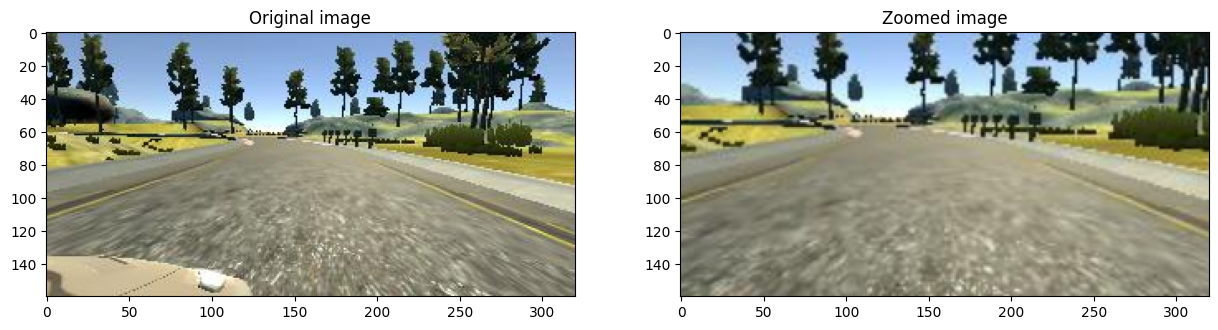

In [17]:
def zoom_image(image):
  zoom = ia.Affine(scale=(1,1.8))
  image = zoom.augment_image(image)
  return image

image = img_paths[random.randint(1,1000)]
og_img = mpimg.imread(image)
zoom_img = zoom_image(og_img)

fig, axs = plt.subplots(1,2, figsize=(15,10))

axs[0].imshow(og_img)
axs[0].set_title("Original image")

axs[1].imshow(zoom_img)
axs[1].set_title("Zoomed image")

Text(0.5, 1.0, 'Panned image')

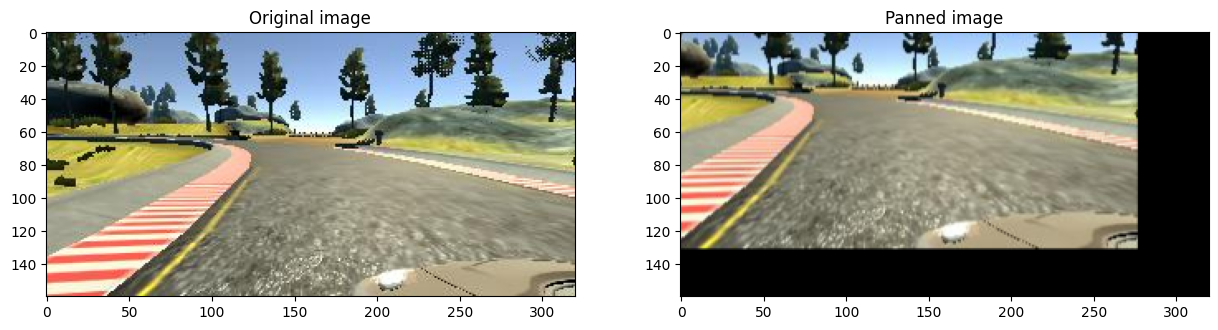

In [18]:
def panned_img(image):
  pan = ia.Affine(translate_percent={"x" : (0.1,-0.2), "y": (0.1,-0.2)})
  image = pan.augment_image(image)
  return image


image = img_paths[random.randint(1,1000)]
og_img = mpimg.imread(image)
pan_img = panned_img(og_img)

fig, axs = plt.subplots(1,2, figsize=(15,10))

axs[0].imshow(og_img)
axs[0].set_title("Original image")

axs[1].imshow(pan_img)
axs[1].set_title("Panned image")

Text(0.5, 1.0, 'Bright image')

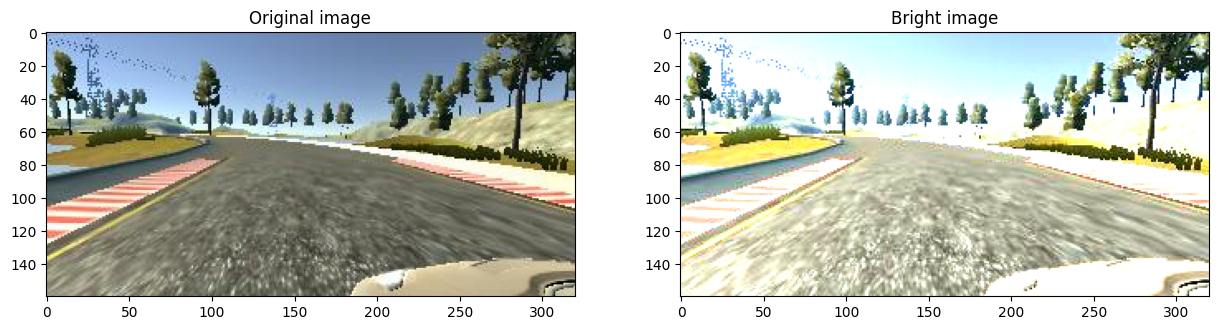

In [19]:
def img_random_brightness(image):
  bright = ia.Multiply((1,1.8))
  image = bright.augment_image(image)
  return image


image = img_paths[random.randint(1,1000)]
og_img = mpimg.imread(image)
bright_img = img_random_brightness(og_img)

fig, axs = plt.subplots(1,2, figsize=(15,10))

axs[0].imshow(og_img)
axs[0].set_title("Original image")

axs[1].imshow(bright_img)
axs[1].set_title("Bright image")

Text(0.5, 1.0, 'Flipped image Steering : 0.0597693')

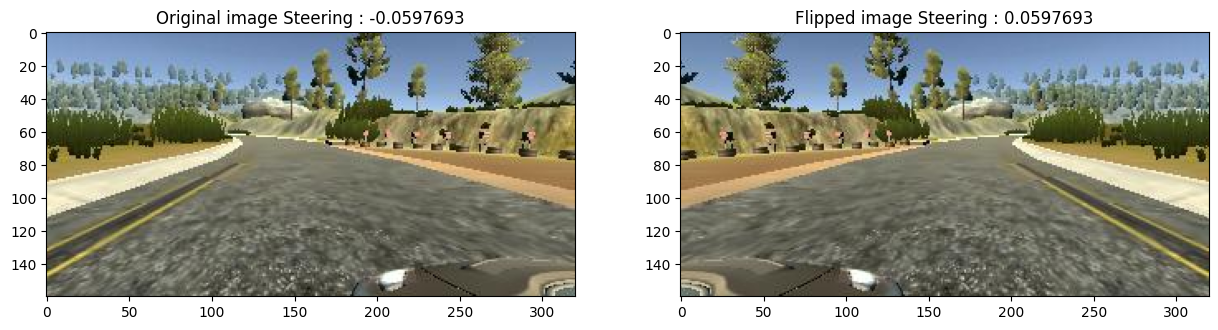

In [20]:
def img_random_flip(image,steering_angle):
  image = cv.flip(image,1)
  steering_angle = -steering_angle
  return image,steering_angle

index = random.randint(1,1000)
image = img_paths[index]
og_img = mpimg.imread(image)
flip_img, steering_angle = img_random_flip(og_img,steerings[index])

fig, axs = plt.subplots(1,2, figsize=(15,10))

axs[0].imshow(og_img)
axs[0].set_title("Original image Steering : " + str(steerings[index]))

axs[1].imshow(flip_img)
axs[1].set_title("Flipped image Steering : " + str(steering_angle))

In [21]:
def random_augment(image,steering_angle):
  img = mpimg.imread(image)
  if np.random.rand()<0.5:
    img = zoom_image(img)
  if np.random.rand() < 0.5:
    img = panned_img(img)
  if np.random.rand() < 0.5:
    img = img_random_brightness(img)
  if np.random.rand() < 0.5:
    img, steering_angle = img_random_flip(img,steering_angle)

  return img, steering_angle

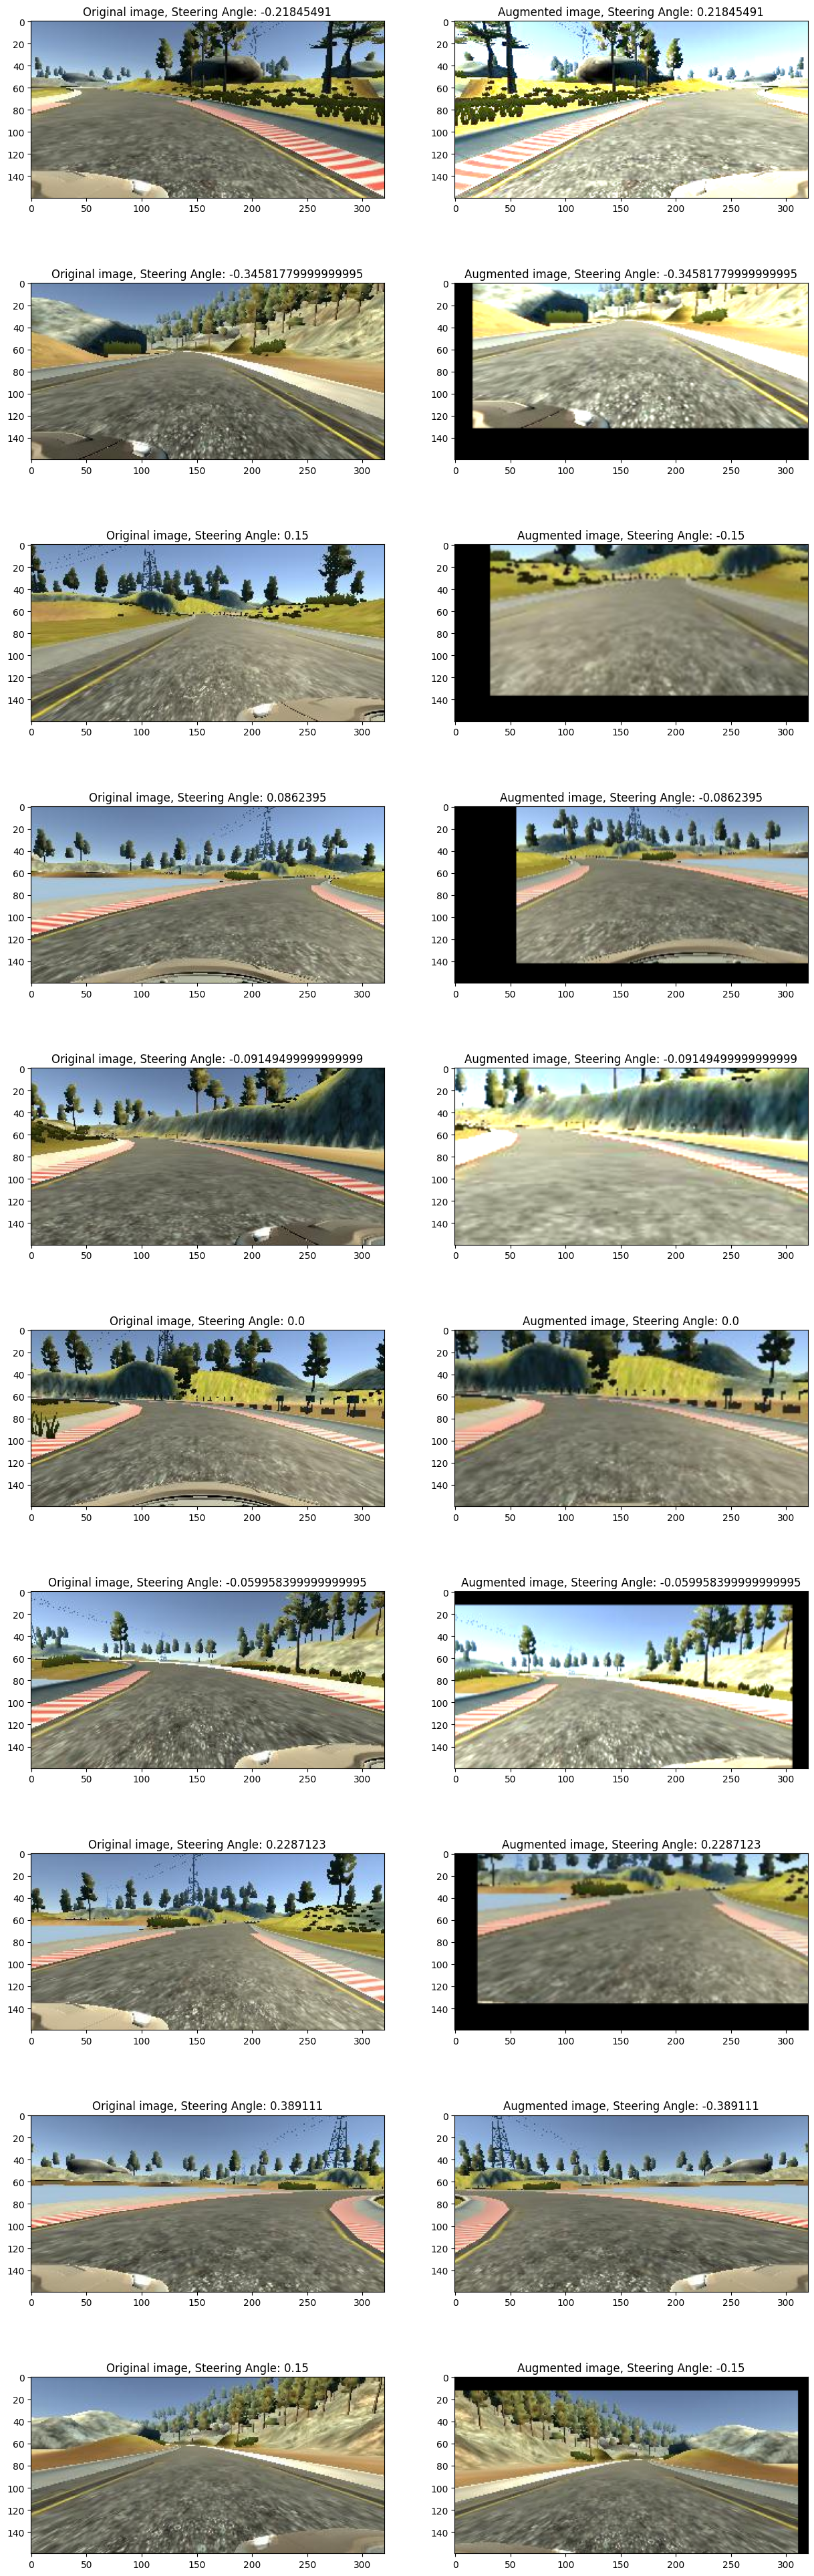

In [22]:
rows = 10
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(15, 50))
for i in range(10):
    c = np.random.randint(1, 1000)
    img = img_paths[c]
    steering_angle = steerings[c]

    # Load the image and convert it to RGB
    image = mpimg.imread(img)
    # Apply random augmentation
    aug_img, steering = random_augment(img, steering_angle)

    # Display the original and augmented images
    axs[i][0].imshow(image)
    axs[i][0].set_title("Original image, Steering Angle: " + str(steering_angle))

    axs[i][1].imshow(aug_img)
    axs[i][1].set_title("Augmented image, Steering Angle: " + str(steering))


In [23]:
def preprocess_img(image):
  image = image[55:140,:,:]
  image = cv.cvtColor(image,cv.COLOR_RGB2YUV)
  image = cv.GaussianBlur(image,(3,3),0)
  image = cv.resize(image,(200,66))
  image = image/255;
  return image


Text(0.5, 1.0, 'Preprocessed image')

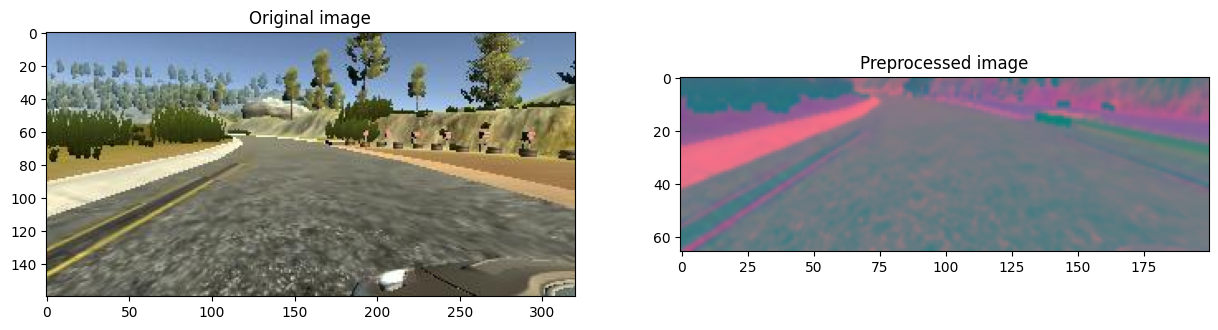

In [24]:
img = mpimg.imread(img_paths[100])
preprocessed_img = preprocess_img(img)

fig, axs = plt.subplots(1,2, figsize=(15,10))

axs[0].imshow(og_img)
axs[0].set_title("Original image")

axs[1].imshow(preprocessed_img)
axs[1].set_title("Preprocessed image")

In [25]:
def batch_generator(img_paths,steerings,batch_size,istraining):
  while True:
    batch_imgs = []
    batch_steering = []
    for i in range(batch_size):
      index = np.random.randint(0,len(img_paths)-1)
      if istraining:
        img, steering = random_augment(img_paths[index],steerings[index])
      else:
        img = mpimg.imread(img_paths[index])
        steering = steerings[index]

      img = preprocess_img(img)
      batch_imgs.append(img)
      batch_steering.append(steering)
      yield(np.asarray(batch_imgs),np.asarray(batch_steering))

Text(0.5, 1.0, 'Test image')

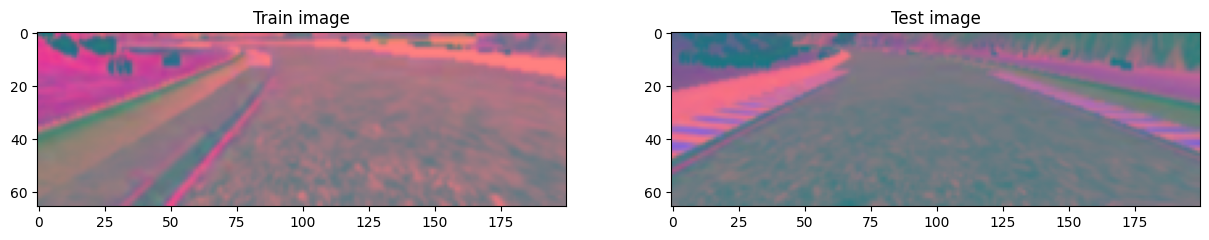

In [26]:
xtrain_gen, ytrain_gen = next(batch_generator(xtrain,ytrain,1,1))
xtest_gen, ytest_gen = next(batch_generator(xtest,ytest,1,0))

fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].imshow(xtrain_gen[0])
axs[0].set_title("Train image")
axs[1].imshow(xtest_gen[0])
axs[1].set_title("Test image")

In [27]:
def nvidia_model():
  model = Sequential()
  model.add(BatchNormalization(input_shape=(66, 200, 3)))
  model.add(Conv2D(24, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))

  model.add(Flatten())

  model.add(Dense(1164, activation='elu'))
  model.add(Dense(100, activation='elu'))
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation='elu'))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

In [28]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 66, 200, 3)          │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 20, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 18, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1164)                │       1,342,092 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │         116,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,595,523 (6.09 MB)

 Trainable params: 1,595,517 (6.09 MB)

 Non-trainable params: 6 (24.00 B)

None


In [29]:

history = model.fit(
    batch_generator(xtrain, ytrain, 100, 1),
    steps_per_epoch=350,
    epochs=20,  # Increase the number of epochs to give the model more time to train
    validation_data=batch_generator(xtest, ytest, 70, 0),
    validation_steps=125,
    verbose=2,
    shuffle=1,
)


Epoch 1/20
350/350 - 291s - 830ms/step - accuracy: 0.1216 - loss: 0.0452 - val_accuracy: 0.1006 - val_loss: 0.0766
Epoch 2/20
350/350 - 262s - 750ms/step - accuracy: 0.0925 - loss: 0.0243 - val_accuracy: 0.0772 - val_loss: 0.0624
Epoch 3/20
350/350 - 238s - 680ms/step - accuracy: 0.1149 - loss: 70.1583 - val_accuracy: 0.0733 - val_loss: 2.8404
Epoch 4/20
350/350 - 227s - 649ms/step - accuracy: 0.0988 - loss: 1.7739 - val_accuracy: 0.0932 - val_loss: 1.0037
Epoch 5/20
350/350 - 199s - 570ms/step - accuracy: 0.0936 - loss: 0.5691 - val_accuracy: 0.0966 - val_loss: 0.2626
Epoch 6/20
350/350 - 157s - 449ms/step - accuracy: 0.0909 - loss: 0.2125 - val_accuracy: 0.1066 - val_loss: 0.0957
Epoch 7/20
350/350 - 124s - 353ms/step - accuracy: 0.1170 - loss: 0.0843 - val_accuracy: 0.0860 - val_loss: 0.0746
Epoch 8/20
350/350 - 144s - 411ms/step - accuracy: 0.1187 - loss: 0.0809 - val_accuracy: 0.0651 - val_loss: 0.0711
Epoch 9/20
350/350 - 130s - 371ms/step - accuracy: 0.1025 - loss: 0.0727 - val_

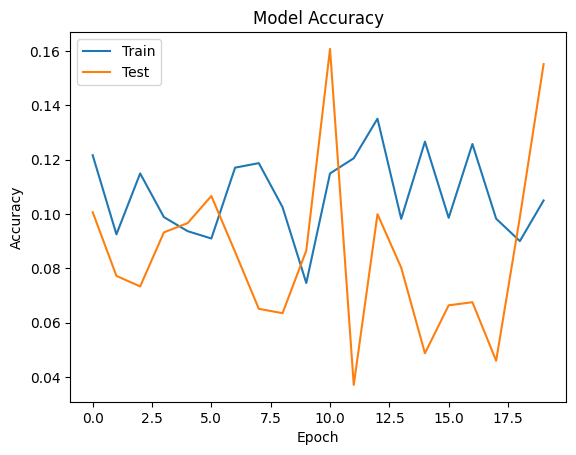

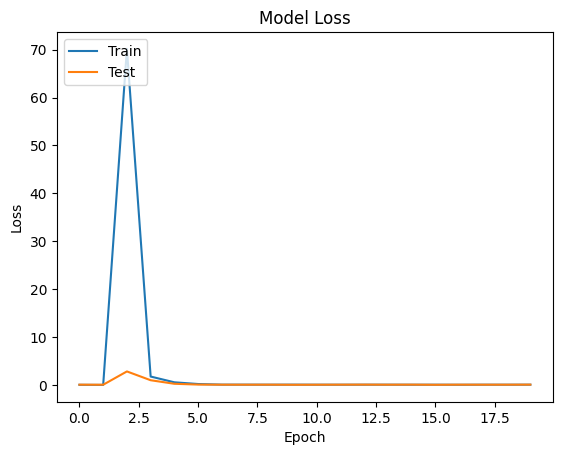

In [30]:
def plot_results(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_results(history)